# Credit Card Fraud Detection

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

We will choose a model based on the precision and recall curve (and the area under it), which are more insightful metrics than accuracy in such an un-balanced dataset. 

In [1]:
import pandas as pd

df=pd.read_csv('creditcard.csv')

df.shape

(284807, 31)

# Splitting the data into training and test sets:

In [2]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])

# Exploring the data:

In [3]:
df_train.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
265518,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,...,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32,0
180305,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,...,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99,0
42664,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,...,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227845 entries, 265518 to 17677
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    227845 non-null  float64
 1   V1      227845 non-null  float64
 2   V2      227845 non-null  float64
 3   V3      227845 non-null  float64
 4   V4      227845 non-null  float64
 5   V5      227845 non-null  float64
 6   V6      227845 non-null  float64
 7   V7      227845 non-null  float64
 8   V8      227845 non-null  float64
 9   V9      227845 non-null  float64
 10  V10     227845 non-null  float64
 11  V11     227845 non-null  float64
 12  V12     227845 non-null  float64
 13  V13     227845 non-null  float64
 14  V14     227845 non-null  float64
 15  V15     227845 non-null  float64
 16  V16     227845 non-null  float64
 17  V17     227845 non-null  float64
 18  V18     227845 non-null  float64
 19  V19     227845 non-null  float64
 20  V20     227845 non-null  float64
 21  V21   

## Plotting features' histograms:

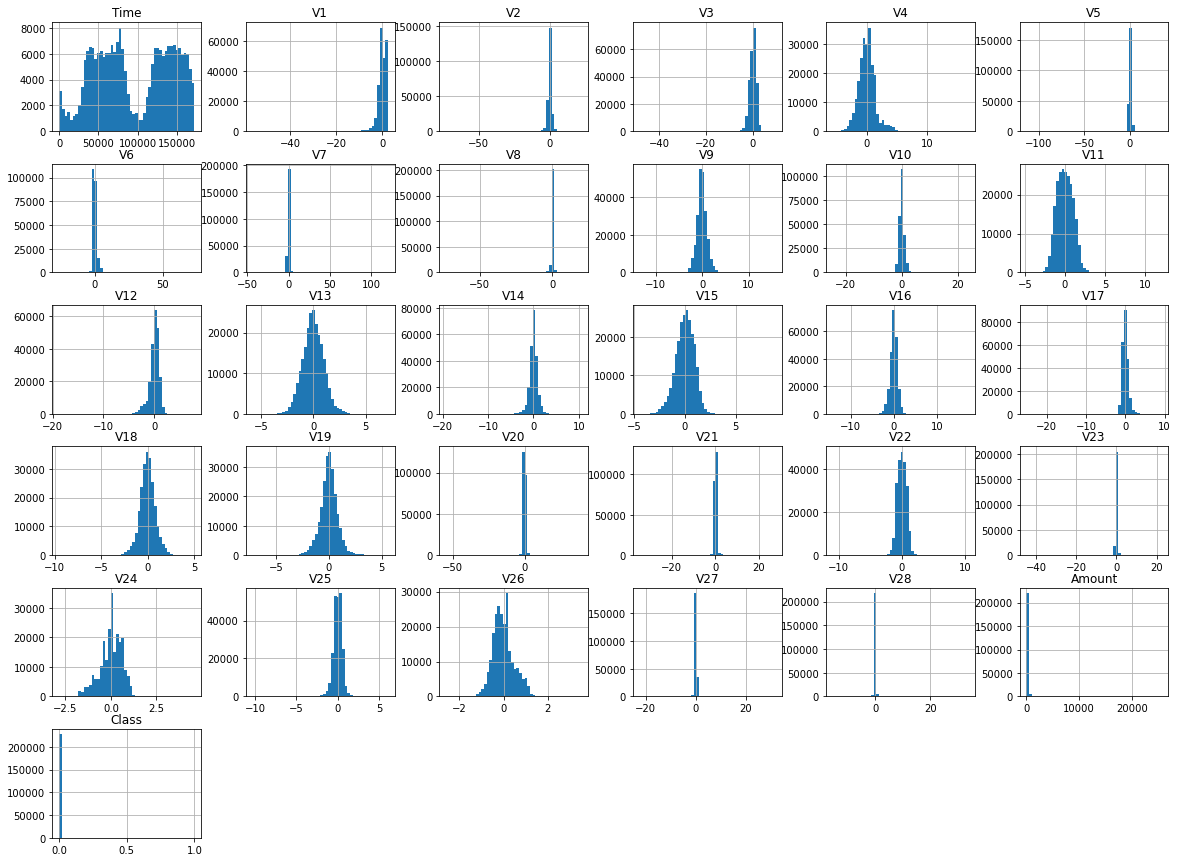

In [5]:
import matplotlib.pyplot as plt

df_train.hist(bins=50, figsize=(20,15))
plt.show()

## Calculating correlations between the labels and the features:

In [6]:
corr_matrix = df_train.corr()
corr_matrix["Class"].sort_values(ascending=False)

Class     1.000000
V11       0.153709
V4        0.135014
V2        0.090586
V21       0.035588
V19       0.032380
V8        0.020552
V20       0.019385
V27       0.016034
V28       0.009810
Amount    0.006211
V26       0.004119
V22       0.002926
V25       0.001618
V23      -0.004169
V15      -0.005705
V13      -0.005861
V24      -0.007483
Time     -0.010564
V6       -0.043334
V5       -0.093578
V9       -0.098247
V1       -0.100041
V18      -0.108732
V7       -0.186184
V16      -0.193826
V3       -0.194135
V10      -0.217894
V12      -0.259989
V14      -0.301054
V17      -0.321937
Name: Class, dtype: float64

# Data preparations:

In [7]:
import numpy as np

X_train=df_train.to_numpy()[:,:30]
y_train=df_train['Class'].to_numpy()

X_test=df_test.to_numpy()[:,:30]
y_test=df_test['Class'].to_numpy()

In [8]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Training an XGBoost model:

We will apply early stopping with the 'aucpr' metric which is the area under the precision-recall curve, and when fine-tuning we will use the 'average_precision' scoring which is the same. 

Setting aside a validation set:

In [9]:
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train, y_train, test_size=0.2, 
                                                                  random_state=42, stratify=y_train)

## Fine-tuning:

In [10]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(n_estimators=100, objective='binary:logitraw', random_state=42, use_label_encoder=False) 

fit_params={'verbose': False,
            'eval_metric': 'aucpr',
            'eval_set': [(X_val_xgb, y_val_xgb)], 
            'early_stopping_rounds': 10}

param_grid = [{'max_depth': [15, 20, 25], 
               'learning_rate': [0.2, 0.5, 0.7]}]

grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='average_precision', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_xgb, y_train_xgb, **fit_params)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='binary:logitraw',
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
      

In [11]:
grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 15}

## Plotting the Precision-Recall curve:

first we want 'clean' predictions on the training set, using cross_val_predict:

In [12]:
from sklearn.model_selection import cross_val_predict

xgb_clf_curve = xgb.XGBClassifier(max_depth=15, n_estimators=100, learning_rate=0.2, objective='binary:logitraw', 
                                  random_state=42, use_label_encoder=False) 

fit_params={'eval_metric': 'aucpr',
            'eval_set': [(X_val_xgb, y_val_xgb)], 
            'early_stopping_rounds': 10}

y_scores = cross_val_predict(xgb_clf_curve, X_train_xgb, y_train_xgb, cv=5, method="predict_proba", 
                             fit_params=fit_params, n_jobs=-1)

In [13]:
y_scores=y_scores[:,1]

With these scores we compute precision and recall for all possible thresholds: 

In [14]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_xgb, y_scores)

precisions.shape, recalls.shape, thresholds.shape

((32863,), (32863,), (32862,))

In [15]:
precisions=precisions[:-1]
recalls=recalls[:-1]

In [16]:
precisions.shape, recalls.shape, thresholds.shape

((32862,), (32862,), (32862,))

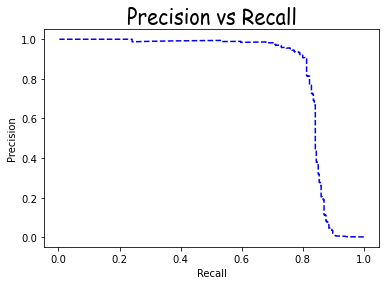

In [17]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 20})

plot_precision_vs_recall(precisions, recalls)
plt.show()

## Suggesting threshold alternatives:

### Choosing the primary elbow in the PR curve:

It makes the most sense, producing both high precision and high recall. Said elbow appears at recall value of 0.8. Hence:

In [18]:
np.where(recalls>=0.8)[0][-1]

32591

The precision and recall we receive are:

In [19]:
precisions[32591], recalls[32591] 

(0.9197080291970803, 0.8)

Looking at it on the PR curve - the red dot:

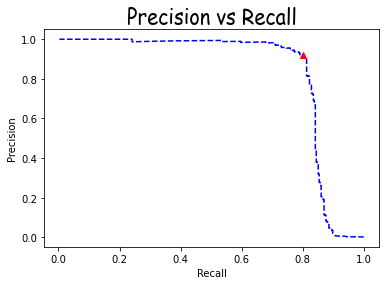

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 20})
    plt.plot(recalls[32591], precisions[32591], 'r^--', label='1222')

plot_precision_vs_recall(precisions, recalls)
plt.show()

The corresponding threshold is:

In [21]:
thresholds[32591]

-0.47505212

### Choosing the secondary elbow in the PR curve:

If precision is vital we will take the 'smaller' elbow at recall value of 0.69: 

In [22]:
np.where(recalls>=0.69)[0][-1]

32642

The precision and recall we receive are:

In [23]:
precisions[32642], recalls[32642] 

(0.9819819819819819, 0.692063492063492)

Looking at it on the PR curve - the red dot:

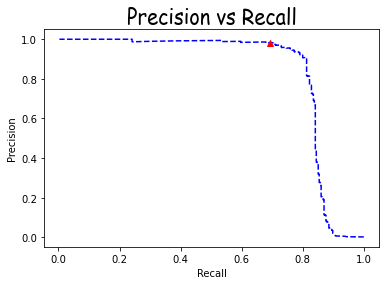

In [24]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 20})
    plt.plot(recalls[32642], precisions[32642], 'r^--', label='1222')

plot_precision_vs_recall(precisions, recalls)
plt.show()

The corresponding threshold is:

In [25]:
thresholds[32642]

2.6995952

For this project we go with option number 1, which is the primary elbow:

In [26]:
model_threshold=-0.47505212

## Final model training:

In [27]:
xgb_clf = xgb.XGBClassifier(max_depth=15, learning_rate=0.3, n_estimators=100, objective='binary:logitraw', random_state=42, use_label_encoder=False) 

fit_params={'verbose': False,
            'eval_metric': 'aucpr',
            'eval_set': [(X_val_xgb, y_val_xgb)], 
            'early_stopping_rounds': 10}

xgb_clf.fit(X_train_xgb, y_train_xgb, **fit_params)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='binary:logitraw', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

The predictions will be done the following way:

In [28]:
def xgb_predict(X, model, model_threshold):
    return (model.predict_proba(X)[:,1] >= model_threshold)

Computing Precision, Recall and F1 score on the the validation set:

In [29]:
from sklearn.metrics import recall_score, precision_score, f1_score

y_val_pred=xgb_predict(X_val_xgb, xgb_clf, model_threshold)

print("Precision:", precision_score(y_val_xgb, y_val_pred))
print("Recall:", recall_score(y_val_xgb, y_val_pred))
print("F1 Score:", f1_score(y_val_xgb, y_val_pred))

Precision: 0.921875
Recall: 0.7468354430379747
F1 Score: 0.8251748251748252


# Testing the model on the test set:

Computing Precision, Recall and F1 score on the the test set:

In [30]:
y_test_pred=xgb_predict(X_test, xgb_clf, model_threshold)

print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))

Precision: 0.9032258064516129
Recall: 0.8571428571428571
F1 Score: 0.8795811518324608
